# Real World Health Data final project

This notebook visualizes daily health data that I recorded to understand why I had frequent headaches. I tracked lifestyle factors like sleep, hydration, physical activity, salad consumption, screen time over 4 weeks to understand the variables influencing my headaches. 

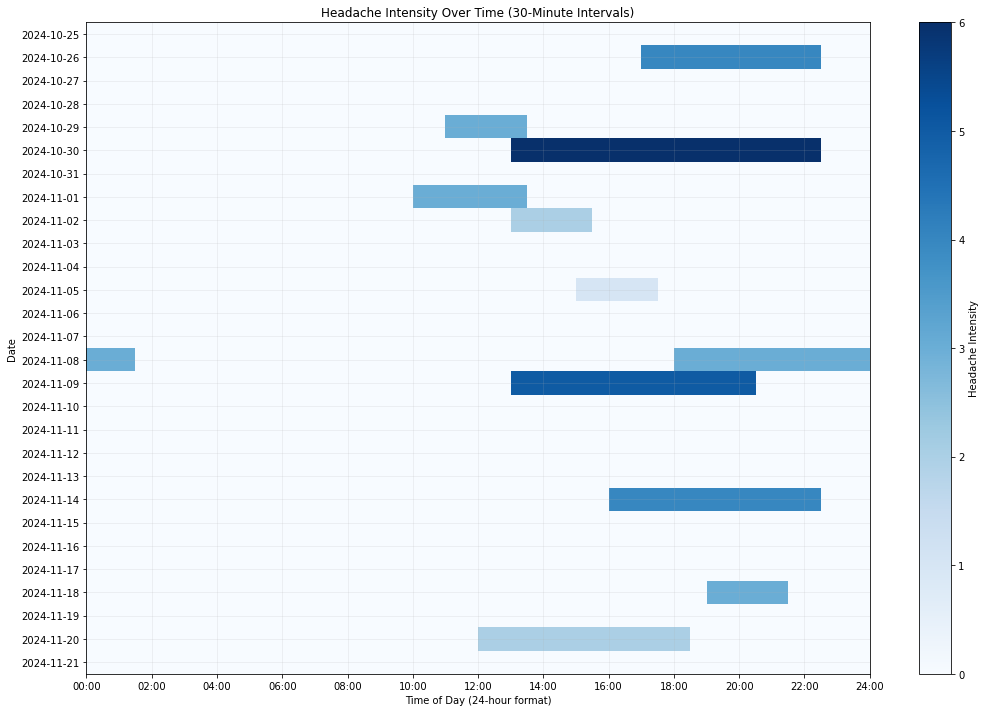

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


file_path = '/Users/sukritigupta/downloads/activity_tracking.xlsx'
df = pd.read_excel(file_path)


df['date'] = pd.to_datetime(df['date'])

def parse_simple_time(time_str):
    if pd.isna(time_str):
        return pd.NaT
    try:
        
        time_str = str(time_str).lower().replace(' ', '')
        
        if '.' in time_str:
            parts = time_str.split('.')
            hour = int(parts[0])
            minutes = parts[1].replace('am','').replace('pm','')
            minutes = int(minutes) if len(minutes) <= 2 else int(minutes[:2])
            
            if 'pm' in time_str.lower() and hour != 12:
                hour += 12
            elif 'am' in time_str.lower() and hour == 12:
                hour = 0
        else:
            if 'am' in time_str:
                hour = int(time_str.replace('am', ''))
                if hour == 12:
                    hour = 0
                minutes = 0
            elif 'pm' in time_str:
                hour = int(time_str.replace('pm', ''))
                if hour != 12:
                    hour = hour + 12
                minutes = 0
            else:
                return pd.NaT
                
        return pd.to_datetime(f"{hour:02d}:{minutes:02d}")
    except:
        print(f"Could not parse time: {time_str}")
        return pd.NaT

df['headache start time'] = df['headache start time'].apply(parse_simple_time)
df['headache end time'] = df['headache end time'].apply(parse_simple_time)

def map_to_intervals(start, end):
    if pd.isna(start) or pd.isna(end):
        return []
    
    interval_start = start.hour * 2  
    interval_end = end.hour * 2
    
    if interval_end < interval_start:
        interval_end += 48
    
    intervals = list(range(interval_start, interval_end + 1))
    return [i % 48 for i in intervals]

df['headache_intervals'] = df.apply(
    lambda row: map_to_intervals(row['headache start time'], row['headache end time']),
    axis=1
)

# Prepare raster plot data
dates = df['date'].dt.date
unique_dates = sorted(dates.unique())
num_days = len(unique_dates)
time_blocks = 48
raster_data = np.zeros((num_days, time_blocks))

date_to_index = {date: i for i, date in enumerate(unique_dates)}
for _, row in df.iterrows():
    if row['headache_intensity'] > 0:  # Only plot when there's a headache
        date_idx = date_to_index[row['date'].date()]
        for interval in row['headache_intervals']:
            if 0 <= interval < time_blocks:
                raster_data[date_idx, interval] = row['headache_intensity']


plt.figure(figsize=(15, 10))
plt.imshow(raster_data, aspect='auto', cmap='Blues', extent=[0, 24, 0, num_days])
plt.colorbar(label='Headache Intensity')

plt.yticks(np.arange(num_days) + 0.5, [date.strftime('%Y-%m-%d') for date in unique_dates])
plt.xticks(np.arange(0, 25, 2), [f"{int(hr):02d}:00" for hr in np.arange(0, 25, 2)])

plt.xlabel('Time of Day (24-hour format)')
plt.ylabel('Date')
plt.title('Headache Intensity Over Time (30-Minute Intervals)')
plt.gca().invert_yaxis()

plt.grid(True, alpha=0.2)

plt.tight_layout()
plt.savefig('headache_raster.png', dpi=300, bbox_inches='tight')
plt.show()

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def clean_sleep_duration(x):
    if pd.isna(x):
        return np.nan
    try:
        return float(str(x).split('hr')[0])
    except:
        return np.nan

def plot_simple_trend(df, col):
    plt.figure(figsize=(10, 6))
    week_means = df.groupby('week')[col].mean()
    
    x_vals = week_means.index.astype(float).to_numpy()
    y_vals = week_means.values.astype(float)
    
    plt.plot(x_vals, y_vals, marker='o')
    plt.title(f'Average {col} by Week')
    plt.xlabel('Week')
    plt.ylabel(col)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{col}_trend.png', dpi=300, bbox_inches='tight')
    plt.close()

def plot_salad_trend(df):
    plt.figure(figsize=(10, 6))
    weekly_salad = df.groupby('week')['salad consumption'].apply(
        lambda x: (x == 'Y').mean() * 100
    )
    x_vals = weekly_salad.index.astype(float).to_numpy()
    y_vals = weekly_salad.values.astype(float)
    
    plt.plot(x_vals, y_vals, marker='o', color='green')
    plt.title('Percentage of Days with Salad Consumption by Week')
    plt.xlabel('Week')
    plt.ylabel('Percentage')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('salad_trend.png', dpi=300, bbox_inches='tight')
    plt.close()

def plot_headache_trend(df):
    plt.figure(figsize=(10, 6))
    weekly_headache = df.groupby('week')['headache_intensity'].apply(
        lambda x: x.notna().mean() * 100
    )
    x_vals = weekly_headache.index.astype(float).to_numpy()
    y_vals = weekly_headache.values.astype(float)
    
    plt.plot(x_vals, y_vals, marker='o', color='red')
    plt.title('Percentage of Days with Headache by Week')
    plt.xlabel('Week')
    plt.ylabel('Percentage')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('headache_trend.png', dpi=300, bbox_inches='tight')
    plt.close()


df['week'] = df['date'].dt.isocalendar().week
df['sleep_duration_hours'] = df['sleep_duration'].apply(clean_sleep_duration)

numeric_cols = ['screentime', 'water', 'sweet_food', 'physical_activity', 'sleep_duration_hours']
for col in numeric_cols:
    if df[col].notna().any():
        plot_simple_trend(df, col)

plot_salad_trend(df)
plot_headache_trend(df)

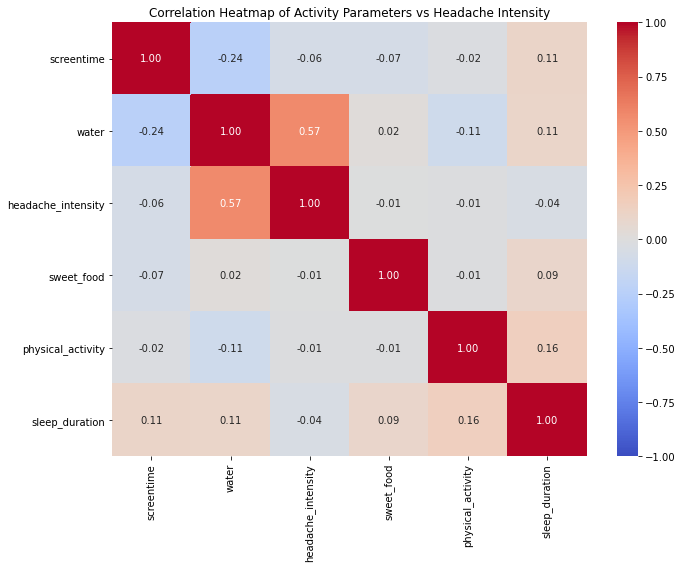

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


df = pd.read_excel('/Users/sukritigupta/downloads/activity_tracking.xlsx')


numeric_columns = ['screentime', 'water', 'headache_intensity', 'sweet_food', 
                  'physical_activity', 'sleep_duration']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

correlation_matrix = df[numeric_columns].corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            annot=True,  # Show correlation values
            cmap='coolwarm',  
            vmin=-1, vmax=1,  
            center=0,
            fmt='.2f')  

plt.title('Correlation Heatmap of Activity Parameters vs Headache Intensity')
plt.tight_layout()
plt.show()

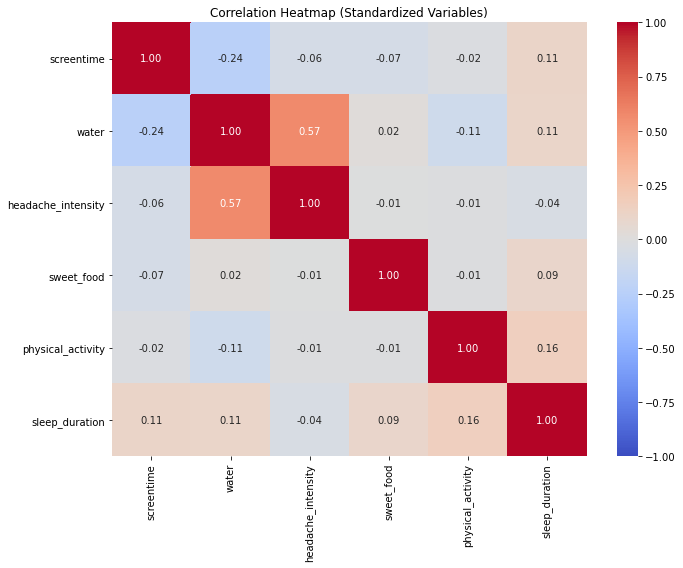

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


df = pd.read_excel('/Users/sukritigupta/downloads/activity_tracking.xlsx')

numeric_columns = ['screentime', 'water', 'headache_intensity', 'sweet_food', 
                  'physical_activity', 'sleep_duration']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

scaler = StandardScaler() # standardize the features
df_scaled = pd.DataFrame(scaler.fit_transform(df[numeric_columns]), 
                        columns=numeric_columns)

correlation_matrix = df_scaled.corr()

#heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            annot=True,
            cmap='coolwarm',
            vmin=-1, vmax=1,
            center=0,
            fmt='.2f')

plt.title('Correlation Heatmap (Standardized Variables)')
plt.tight_layout()
plt.show()

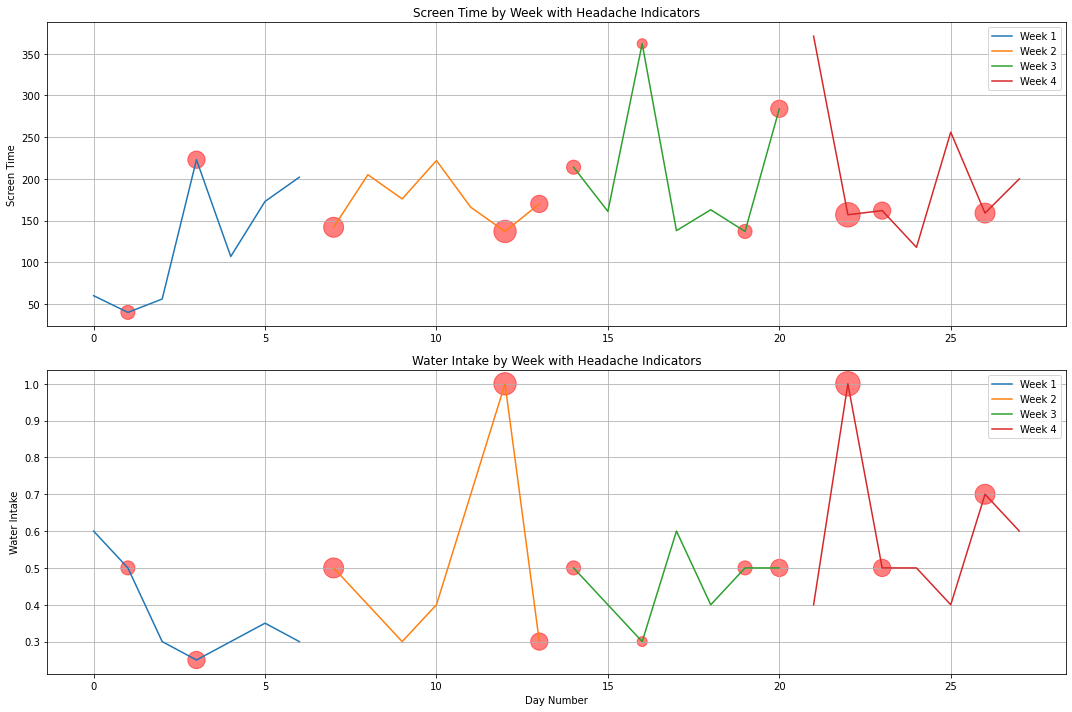

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_excel('/Users/sukritigupta/downloads/activity_tracking.xlsx')
df[['screentime', 'water', 'headache_intensity']] = df[['screentime', 'water', 'headache_intensity']].apply(pd.to_numeric, errors='coerce')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

for week in range(4):
    start_idx = week * 7
    end_idx = start_idx + 7
    week_data = df.iloc[start_idx:end_idx]
    
    days = np.array(range(start_idx, end_idx))
    screentime = week_data['screentime'].to_numpy()
    water = week_data['water'].to_numpy()
    
    ax1.plot(days, screentime, label=f'Week {week+1}')
    ax2.plot(days, water, label=f'Week {week+1}')
    
    # headache dots
    headache_days = week_data[week_data['headache_intensity'] > 0]
    if not headache_days.empty:
        ax1.scatter(headache_days.index, headache_days['screentime'], 
                   s=headache_days['headache_intensity']*100, 
                   alpha=0.5, color='red')
        ax2.scatter(headache_days.index, headache_days['water'], 
                   s=headache_days['headache_intensity']*100, 
                   alpha=0.5, color='red')

ax1.set_title('Screen Time by Week with Headache Indicators')
ax1.set_ylabel('Screen Time')
ax1.grid(True)
ax1.legend()

ax2.set_title('Water Intake by Week with Headache Indicators')
ax2.set_ylabel('Water Intake')
ax2.set_xlabel('Day Number')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

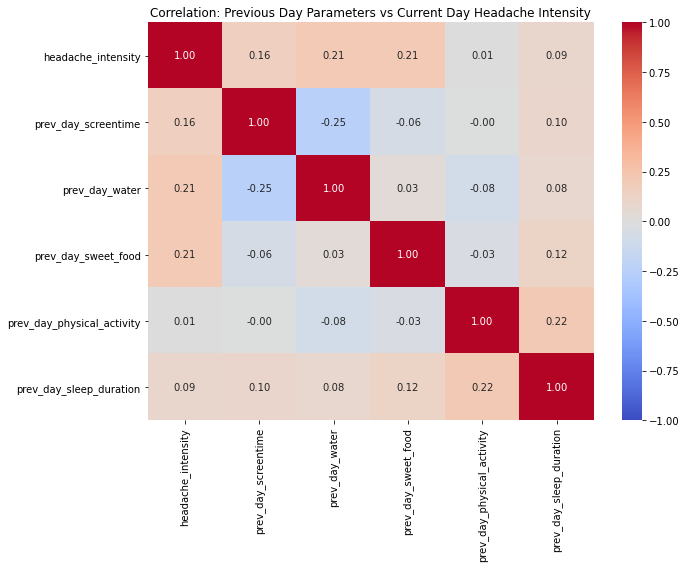

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_excel('/Users/sukritigupta/downloads/activity_tracking.xlsx')

# shifted dataframe (previous day's values)
df_shifted = df.copy()
numeric_columns = ['screentime', 'water', 'sweet_food', 'physical_activity', 'sleep_duration']
for col in numeric_columns:
    df_shifted[f'prev_day_{col}'] = df[col].shift(1)

df_shifted = df_shifted.dropna(subset=[f'prev_day_{col}' for col in numeric_columns])

lag_correlations = df_shifted[['headache_intensity'] + 
                            [f'prev_day_{col}' for col in numeric_columns]].corr()

#heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(lag_correlations, 
            annot=True,
            cmap='coolwarm',
            vmin=-1, vmax=1,
            center=0,
            fmt='.2f')

plt.title('Correlation: Previous Day Parameters vs Current Day Headache Intensity')
plt.tight_layout()
plt.show()